# Importations

In [18]:
import pandas as pd
import numpy as np
import glob
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os


# Config

In [19]:
DATA_DIR = "../data/training_data/"
MODEL_OUT = "../model/xgb_model.json"  # Use .json for XGBoost save_model()
TEST_SIZE = 0.2
SEED = 42

# Loading Data

In [20]:
files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
print(f"Loading {len(files)} CSV files from: {DATA_DIR}")

df_list = []
for file in files:
    try:
        df = pd.read_csv(file, low_memory=False)
        # Filter out rows with invalid Flow Duration
        df = df[pd.to_numeric(df['Flow Duration'], errors='coerce').notnull()]
        # Generalize binary label: 1 = bot/attack, 0 = benign
        df['is_bot'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)
        df_list.append(df)
        print(f"Loaded {os.path.basename(file)}: {len(df):,} rows")
    except Exception as e:
        print(f"Failed to load {file}: {e}")

df_full = pd.concat(df_list, ignore_index=True)
print(f"\nTotal combined rows: {len(df_full):,}")
print("Bot vs Human label distribution:")
print(df_full['is_bot'].value_counts())





Loading 9 CSV files from: ../data/training_data/
Loaded Friday-02-03-2018_TrafficForML_CICFlowMeter.csv: 1,048,575 rows
Loaded Friday-16-02-2018_TrafficForML_CICFlowMeter.csv: 1,048,574 rows
Loaded Friday-23-02-2018_TrafficForML_CICFlowMeter.csv: 1,048,575 rows
Loaded Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv: 7,948,748 rows
Loaded Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv: 331,100 rows
Loaded Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv: 1,048,575 rows
Loaded Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv: 1,048,575 rows
Loaded Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv: 1,048,575 rows
Loaded Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv: 1,048,575 rows

Total combined rows: 15,619,872
Bot vs Human label distribution:
is_bot
0    12940508
1     2679364
Name: count, dtype: int64


# Checking what columns to drop

In [21]:
# Step 1 — drop unwanted
drop_cols = [
    # === Metadata / targets ===
    'Label', 'is_bot', 'Timestamp',

    # === Rarely used flags (binary & mostly 0) ===
    'Fwd URG Flags', 'Bwd URG Flags', 'Fwd PSH Flags', 'Bwd PSH Flags',
    'RST Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',

    # === NaN or unstable columns ===
    'Fwd Byts/b Avg', 'Bwd Byts/b Avg',
    'Fwd Blk Rate Avg', 'Bwd Blk Rate Avg',

    # === Redundant / mirrored columns ===
    'Fwd IAT Tot', 'Fwd IAT Mean', 'Bwd IAT Tot', 'Bwd IAT Mean',  # correlated with Flow Duration
    'Subflow Fwd Pkts', 'Subflow Bwd Pkts',  # same as Tot Fwd/Bwd Pkts
    'Subflow Fwd Byts', 'Subflow Bwd Byts',  # same as TotLen Fwd/Bwd
    'Fwd Seg Size Min',  # nearly constant

    # === Composite/derived redundant columns ===
    'Pkt Size Avg', 'Down/Up Ratio', 'Fwd Pkts/b Avg', 'Bwd Pkts/b Avg',
    'Fwd Act Data Pkts',

    # === Constant or useless temporal stats ===
    'Active Min', 'Idle Min', 'Idle Std', 'Idle Max'
]

X_corr = df_full.drop(columns=drop_cols, errors='ignore')

# Step 2 — convert ALL to numeric (coerce errors into NaN)
for col in X_corr.columns:
    X_corr[col] = pd.to_numeric(X_corr[col], errors='coerce')

# Step 3 — drop columns that became entirely NaN
X_corr.dropna(axis=1, how='all', inplace=True)

# Step 4 — filter only numeric (should now be most columns)
X_corr = X_corr.select_dtypes(include='number')

print(f"Remaining numeric features: {X_corr.shape[1]}")
print(X_corr.columns.tolist())
correlation_matrix = X_corr.corr()
print(correlation_matrix)



Remaining numeric features: 49
['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Mean', 'Src Port']
                   Dst Port  Protocol  Flow Duration  Tot Fwd Pkts  \
Dst Port           1.000000 -0.264498      -0.005113     -0.006519   
Protocol          -0.264

# Preparing features and labels

In [22]:
# === 1. Drop unnecessary columns ===
drop_cols = [
    # === Metadata / targets ===
    'Label', 'is_bot', 'Timestamp',

    # === Rarely used flags (binary & mostly 0) ===
    'Fwd URG Flags', 'Bwd URG Flags', 'Fwd PSH Flags', 'Bwd PSH Flags',
    'RST Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',

    # === NaN or unstable columns ===
    'Fwd Byts/b Avg', 'Bwd Byts/b Avg',
    'Fwd Blk Rate Avg', 'Bwd Blk Rate Avg',

    # === Redundant / mirrored columns ===
    'Fwd IAT Tot', 'Fwd IAT Mean', 'Bwd IAT Tot', 'Bwd IAT Mean',  # correlated with Flow Duration
    'Subflow Fwd Pkts', 'Subflow Bwd Pkts',  # same as Tot Fwd/Bwd Pkts
    'Subflow Fwd Byts', 'Subflow Bwd Byts',  # same as TotLen Fwd/Bwd
    'Fwd Seg Size Min',  # nearly constant

    # === Composite/derived redundant columns ===
    'Pkt Size Avg', 'Down/Up Ratio', 'Fwd Pkts/b Avg', 'Bwd Pkts/b Avg',
    'Fwd Act Data Pkts',

    # === Constant or useless temporal stats ===
    'Active Min', 'Idle Min', 'Idle Std', 'Idle Max'
]


X = df_full.drop(columns=drop_cols, errors='ignore')

# === 2. Convert object columns to numeric when possible
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# === 3. Keep only numeric columns
X = X.select_dtypes(include='number')

# === 4. Clean the data
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# === 5. Get target
y = df_full['is_bot']

# Diagnostics
print(f"\nFeatures shape: {X.shape}")
print("Sample features:\n", X.head())


Features shape: (15619872, 52)
Sample features:
    Dst Port  Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
0       443         6         141385             9             7   
1     49684         6            281             2             1   
2       443         6         279824            11            15   
3       443         6            132             2             0   
4       443         6         274016             9            13   

   TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  \
0            553.0           3773.0            202.0              0.0   
1             38.0              0.0             38.0              0.0   
2           1086.0          10527.0            385.0              0.0   
3              0.0              0.0              0.0              0.0   
4           1285.0           6141.0            517.0              0.0   

   Fwd Pkt Len Mean  ...  Init Fwd Win Byts  Init Bwd Win Byts  Active Mean  \
0         61.444444  ..

# Splitting data into training and testing sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED)

# Training Model

In [24]:
model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
    eval_metric='logloss'
)

model.fit(X_train, y_train)

C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:160: UserWarning: [12:23:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:160: UserWarning: [12:23:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

# Evaluation

In [25]:
y_pred = model.predict(X_test)

print("\nEvaluation on held-out test set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Human (0)', 'Bot (1)']))

C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:160: UserWarning: [12:23:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Evaluation on held-out test set:
Accuracy: 0.9945
Confusion Matrix:
[[2582351    5751]
 [  11479  524394]]

Classification Report:
              precision    recall  f1-score   support

   Human (0)       1.00      1.00      1.00   2588102
     Bot (1)       0.99      0.98      0.98    535873

    accuracy                           0.99   3123975
   macro avg       0.99      0.99      0.99   3123975
weighted avg       0.99      0.99      0.99   3123975



In [36]:
# 1. Get raw probabilities for the “bot” class
y_proba = model.predict_proba(X_test)[:, 1]

y_proba = model.predict_proba(X_test)[:, 1]

for threshold in [0.5, 0.4, 0.3, 0.2]:
    print(f"\n=== Threshold: {threshold} ===")
    y_pred = (y_proba > threshold).astype(int)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Human", "Bot"]))


## 2. Default threshold (0.5)
#y_pred_default = (y_proba > 0.5).astype(int)
#
#from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
#
#print("Confusion Matrix (0.5 threshold):")
#print(confusion_matrix(y_test, y_pred_default))
#print("\nClassification Report:")
#print(classification_report(y_test, y_pred_default, target_names=['Human','Bot']))
#
## 3. Check ROC-AUC as a threshold-independent metric
#print("ROC AUC:", roc_auc_score(y_test, y_proba))



=== Threshold: 0.5 ===
Confusion Matrix:
[[544223      0]
 [ 68881      0]]
Classification Report:


C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

       Human       0.89      1.00      0.94    544223
         Bot       0.00      0.00      0.00     68881

    accuracy                           0.89    613104
   macro avg       0.44      0.50      0.47    613104
weighted avg       0.79      0.89      0.83    613104


=== Threshold: 0.4 ===
Confusion Matrix:
[[544223      0]
 [ 68881      0]]
Classification Report:


C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       Human       0.89      1.00      0.94    544223
         Bot       0.00      0.00      0.00     68881

    accuracy                           0.89    613104
   macro avg       0.44      0.50      0.47    613104
weighted avg       0.79      0.89      0.83    613104


=== Threshold: 0.3 ===
Confusion Matrix:
[[544223      0]
 [ 68881      0]]
Classification Report:


C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

       Human       0.89      1.00      0.94    544223
         Bot       0.00      0.00      0.00     68881

    accuracy                           0.89    613104
   macro avg       0.44      0.50      0.47    613104
weighted avg       0.79      0.89      0.83    613104


=== Threshold: 0.2 ===
Confusion Matrix:
[[544223      0]
 [ 68881      0]]
Classification Report:
              precision    recall  f1-score   support

       Human       0.89      1.00      0.94    544223
         Bot       0.00      0.00      0.00     68881

    accuracy                           0.89    613104
   macro avg       0.44      0.50      0.47    613104
weighted avg       0.79      0.89      0.83    613104



C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# Try a more lenient threshold, e.g. 0.3
y_pred_looser = (y_proba > 0.3).astype(int)

print("Confusion Matrix (0.3 threshold):")
print(confusion_matrix(y_test, y_pred_looser))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_looser, target_names=['Human','Bot']))


Confusion Matrix (0.3 threshold):
[[2571278   16824]
 [   9842  526031]]

Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.99      0.99   2588102
         Bot       0.97      0.98      0.98    535873

    accuracy                           0.99   3123975
   macro avg       0.98      0.99      0.99   3123975
weighted avg       0.99      0.99      0.99   3123975



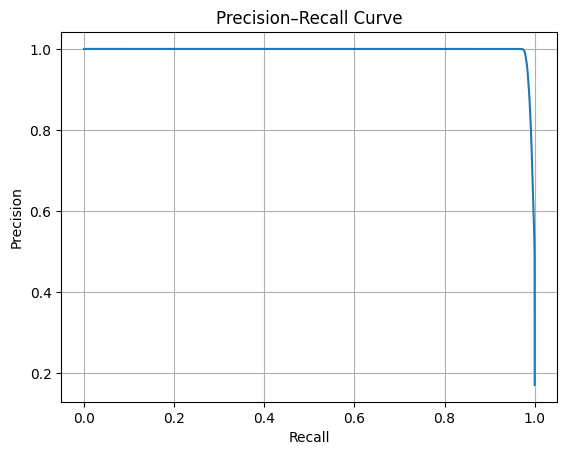

ROC AUC = 0.9988


In [28]:
from sklearn.metrics import precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Get the predicted probabilities for the positive class (bot)
y_proba = model.predict_proba(X_test)[:, 1]

# 2. Compute Precision–Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# 3. Plot Precision vs. Recall
plt.figure()
plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# 4. (Optional) Compute and print ROC AUC
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC = {auc:.4f}")


# Saving the model

In [29]:
model.save_model(MODEL_OUT)
print(f"XGBoost model saved to: {MODEL_OUT}")

XGBoost model saved to: ../model/xgb_model.json


# Testing with external datasets

In [35]:
import pandas as pd
import numpy as np
import glob
import os
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# === CONFIG ===
TEST_DATA_DIR = "../data/testing_data/"
MODEL_PATH = "../model/xgb_model.json"  # Updated to match save_model() usage

# === 1. Load and merge all test CSVs ===
test_files = glob.glob(os.path.join(TEST_DATA_DIR, "*.csv"))
print(f"Found {len(test_files)} test files")

df_list = []
for file in test_files:
    try:
        df = pd.read_csv(file, low_memory=False)
        df = df[pd.to_numeric(df['Flow Duration'], errors='coerce').notnull()]
        df['is_bot'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)
        df_list.append(df)
        print(f"Loaded {os.path.basename(file)}: {len(df):,} rows")
    except Exception as e:
        print(f"Failed to load {file}: {e}")

df_test = pd.concat(df_list, ignore_index=True)
print(f"\nTotal test rows: {len(df_test):,}")
print("is_bot value counts:")
print(df_test['is_bot'].value_counts())

# === 2. Prepare test features ===
X_test = df_test.drop(columns= [
    # === Metadata / targets ===
    'Label', 'is_bot', 'Timestamp',

    # === Rarely used flags (binary & mostly 0) ===
    'Fwd URG Flags', 'Bwd URG Flags', 'Fwd PSH Flags', 'Bwd PSH Flags',
    'RST Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',

    # === NaN or unstable columns ===
    'Fwd Byts/b Avg', 'Bwd Byts/b Avg',
    'Fwd Blk Rate Avg', 'Bwd Blk Rate Avg',

    # === Redundant / mirrored columns ===
    'Fwd IAT Tot', 'Fwd IAT Mean', 'Bwd IAT Tot', 'Bwd IAT Mean',  # correlated with Flow Duration
    'Subflow Fwd Pkts', 'Subflow Bwd Pkts',  # same as Tot Fwd/Bwd Pkts
    'Subflow Fwd Byts', 'Subflow Bwd Byts',  # same as TotLen Fwd/Bwd
    'Fwd Seg Size Min',  # nearly constant

    # === Composite/derived redundant columns ===
    'Pkt Size Avg', 'Down/Up Ratio', 'Fwd Pkts/b Avg', 'Bwd Pkts/b Avg',
    'Fwd Act Data Pkts',

    # === Constant or useless temporal stats ===
    'Active Min', 'Idle Min', 'Idle Std', 'Idle Max'
], errors='ignore')
X_test = X_test.select_dtypes(include='number')
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)

y_test = df_test['is_bot']

# === 3. Load XGBoost model and align features ===
model = XGBClassifier()
model.load_model(MODEL_PATH)

# Align columns to match training
X_test = X_test.reindex(columns=model.feature_names_in_, fill_value=0)

# === 4. Predict and evaluate ===
y_pred = model.predict(X_test)

print("\nEvaluation on test set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Human (0)", "Bot (1)"]))


Found 2 test files
Loaded test.csv: 33 rows
Loaded Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv: 613,071 rows

Total test rows: 613,104
is_bot value counts:
is_bot
0    544223
1     68881
Name: count, dtype: int64

Evaluation on test set:
Accuracy: 0.8877
Confusion Matrix:
[[544223      0]
 [ 68881      0]]

Classification Report:


C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   Human (0)       0.89      1.00      0.94    544223
     Bot (1)       0.00      0.00      0.00     68881

    accuracy                           0.89    613104
   macro avg       0.44      0.50      0.47    613104
weighted avg       0.79      0.89      0.83    613104



C:\Users\1moha\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
